Dataset with FR vaccin stocks from https://public.opendatasoft.com/explore/dataset/covid19-france-stock-vaccin-departement/information/?disjunctive.dep_code&disjunctive.dep_name&disjunctive.reg_code&disjunctive.reg_name&sort=date

Objectives:
- visualize overall vaccin stocks per departement
- look at the breakdown of vaccin types (Pfizer, AZ, etc) in depts with largest stocks

In [1]:
import pandas as pd
import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13,9)

vacs = pd.read_csv("./data/covid19-france-stock-vaccin-departement.csv", 
                   names = ['dept_code','dept_name','type','nb_dose','z1','date','z2','z3','iso3166-3','geo_point'], 
                   skiprows=1,
                   sep=';')

# drop columns
vacs = vacs.drop(labels=['z1','z2','z3'], axis=1)

# type conversions
vacs.date = pd.to_datetime(vacs.date, format="%Y-%m-%d")
vacs.type = pd.Categorical(vacs.type)

# date to run analysis on, few dates per month only
analysis_date = '2021-07-29'
vacs = vacs[vacs.date==analysis_date]

vacs.dtypes
vacs.tail()

,dept_code,dept_name,type,nb_dose,date,iso3166-3,geo_point
7682,64,Pyrénées-Atlantiques,Moderna,570,2021-07-29,FXX,"43.2562009633,-0.760761078137"
7683,86,Vienne,Pfizer,22188,2021-07-29,FXX,"46.5652473368,0.459135535564"
7684,90,Territoire de Belfort,Pfizer,19782,2021-07-29,FXX,"47.6315421523,6.92857662641"
7685,93,Seine-Saint-Denis,Moderna,13580,2021-07-29,FXX,"48.9177348857,2.47790682097"
7686,93,Seine-Saint-Denis,AstraZeneca,2250,2021-07-29,FXX,"48.9177348857,2.47790682097"


Number of vaccins per department
----

In [ ]:
dose_per_dept = vacs.groupby(['dept_code', 'dept_name'], as_index=False)['nb_dose'].sum()
dose_per_dept.nlargest(9, 'nb_dose')

In [3]:
import geopandas
base = geopandas.read_file('./data/departements-20180101.shp')
base.head()

,code_insee,nom,nuts3,wikipedia,surf_km2,geometry
0,974,La Réunion,FR940,fr:La Réunion,2505.0,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,11,Aude,FR811,fr:Aude (département),6343.0,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
2,43,Haute-Loire,FR723,fr:Haute-Loire,5003.0,"POLYGON ((3.08206 45.28988, 3.08209 45.29031, ..."
3,13,Bouches-du-Rhône,FR823,fr:Bouches-du-Rhône,5247.0,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,47,Lot-et-Garonne,FR614,fr:Lot-et-Garonne,5385.0,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."


In [4]:
# filter out three-letter dpt codes (outre-mer?) 
base = base[base.code_insee.str.len() <= 2]

Text(0.5, 1.0, 'Vaccin stock per dpt - 2021-07-29')

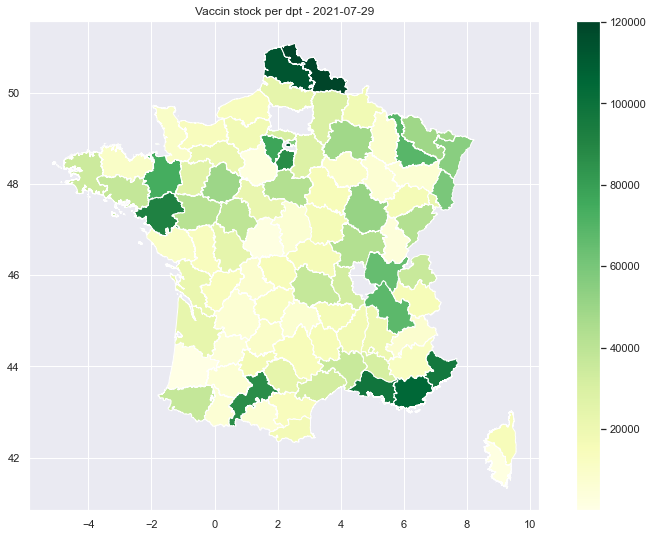

In [5]:
mg = pd.merge(base, dose_per_dept, left_on='code_insee', right_on='dept_code')
ax = mg.plot(column='nb_dose', cmap='YlGn', legend=True)
ax.set_title('Vaccin stock per dpt - ' + analysis_date)

Breakdown per vaccin type in the 9 depts with largest stocks
-----------------------------------------------------------------------

In [6]:
# df top9 departments with most vaccines
top9 = vacs[vacs.dept_code.isin(dose_per_dept.nlargest(9, 'nb_dose').dept_code)]

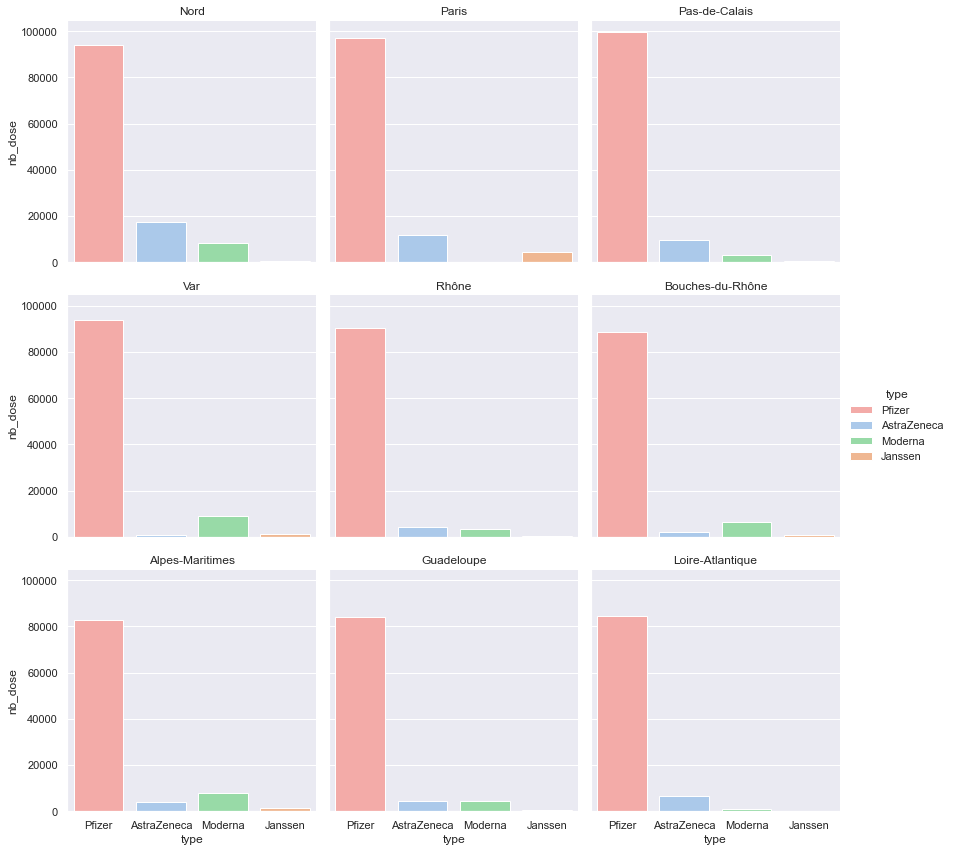

In [7]:
# Initialize grid and map barplots
grid = sns.FacetGrid(top9, col='dept_name', hue='type', palette='pastel',
                     col_order = dose_per_dept.nlargest(9, 'nb_dose').dept_name,
                     col_wrap=3, height=4)
vac_list = ['Pfizer','AstraZeneca','Moderna','Janssen']
grid.map(sns.barplot,'type','nb_dose', order=vac_list)
grid.set_titles(col_template="{col_name}", row_template="{row_name}")
grid.add_legend(label_order=vac_list)